### Monte-Carlo transport project
Simulate electron transport in a cylindrical Geiger counter filled 
with Helium gas.

This project attempts to simulate the microscopic transport of electrons in Helium gas under the influence of an electric field. The challenge for this modelling task is to implement the physics of electron-atom scattering with the kinematics of the Lorentz force on an electron in an electric field. Scattering is a quantum process which takes place probabilistically depending on the kinetic energy of the charge. However, this kinetic energy depends on the discrete step in time the program decides to take since the electric field keeps accelerating the electron. 

The contradiction between the requirement for a constant, discrete time step and a probabilitic waiting time step, i.e. the time to the next scattering reaction as a function of kinetic energy, is solved by the null-collision simulation method. A description of the method can be found below. Find all technical requirements for the code below.

- Write a function **run(charges, voltage)** that starts the simulation and returns a list of lists of arrays of electron interaction locations in 3D in order to draw the required scatterplot, see below. Input **charges** is a list of a single array with the starting position of the first electron (in 3D) and represents the charge pool container (the list) to store all electron starting locations that have not yet been transported. The **voltage** input is a number that needs to reach the electric field calculation function (for you to write) for flexibility in the simulation configuration.

- Geometry: Let the cylindrical Geiger counter long axis be defined along the z-axis. Set the anode wire with radius 8.0e-5 m at the origin; the cathode cylinder radius is 1.0e-2 m and the anode bias is set at 1000 Volt. Start a single electron at a radial distance of 3.0e-3 m.

- Transport should be simulated using the null-collision method. A pseudo-code demonstrating the method is shown and discussed below.

- Electrons can scatter elastically or ionize the gas using inelastic scattering. Each ionization should increase the number  of electrons to transport by one (store it in the charge pool). The original electron which requires further, subsequent, transport should carry on after ionization (however, see condition below). The two cross section functions have been pre-coded for you. A function randomly choosing between the processes as a function of energy in eV is also given.

- In case of elastic scattering, simply change (i.e. rotate) the velocity vector direction randomly in the forward hemisphere, i.e. towards the wire, and leave the magnitude unchanged. The only velocity magnitude (and direction) changes in the entire code should arise from acceleration due to the electric field. That 'forward' scattering statement is an arbitrary, simple, requirement. Forward scattering in electron-atom interactions is dominant but the angular distributions (which we would realistically need here) are complicated hence ignore them here.

- The case of an inelastic collision should reset the electron velocity vector to thermal energy (0.025 eV), set the dynamic null collision constant `kv=0` (see below) and store the location of the electron in the charge pool (identical to creating an additional electron since the original carries on being transported) for later transport.

- Count all interactions for all electrons and store all inelastic collision locations and 1 in 1000 elastic collision locations. Otherwise, there will be too many collisions to store and to draw! The model solution produced between 7-11 thousand electrons in test runs with the given conditions, each with thousands of interaction locations stored.

- Suppress single electron starting positions from the pool of charges closer than 5e-4 m: 

```python
if math.hypot(pos[0], pos[1]) < 5.0e-4: # block avalanche at rad=5.0e-4 m
    places.append(pos)
    stopFlag = True
```
    
assuming the location vector 'pos' is created from the charge pool container and 'stopFlag' is the boolean checked for the transport `while` loop. This suppression should keep execution time of your pure python code below 90 minutes (on my humble 4-core machine), hopefully.

---

#### Marking
As always for Python projects, find the correct solution first, optimize second. A correct figure indicates a successful code hence attracts 15 out of 20 marks (with the caveat of checking the code for correctness, of course, including subtraction of marks for mistakes along the way). The final 5 marks are awarded for speed of code execution.
- Draw a 2-D scatterplot of electron transport interactions. The picture should reveal the electron avalanche near the wire for full marks on graphics (with axis labels). If the outline of the wire happens to be visible in a 3-D scatterplot then that plot would also be accepted.

- This simulation benefits greatly from efforts to speed up the execution. On the assessment workstation (4-cores) a speed-up factor between 20-30 has been achieved comparing the pure python version with an optimized version. Full marks will be awarded for any speed-up factor of 10 or more compared to the pure python model solution. Clearly, the given cross section functions are also available for optimization in order to reach such speed-ups. They are being called millions of times. Therefore, please print(!) the process time of your `run(charges, voltage)` function for a manual assessment using

```python
start = time.process_time()
res = run(single, bias) # just example variable names, choose as you wish
stop = time.process_time()
print('Process time: ', (stop-start))
``` 

- In case no full marks can be awarded according to the items above, partial marks will be awarded manually, depending on how many required parts of the full code have been completed.

---

### Null collision method and coding hints
The null collision method can be interpreted as an Accept/Reject Monte-Carlo method. Here, accept stands for 'elastic collision takes place', reject then corresponds to 'electron remains in free flight'. The function transporting a single electron should contain the null collision method set up

```python
kmax = 2.0e-12 # null collision constant
tau = 1.0 / (nDensity * kmax)
```

with nDensity the number density of the gas derived from the Helium density
`density = 0.1664 # [kg/m^3] NTP He gas at 293 K`
and 'tau' the time constant of the null collision method. The 'tau' constant is required in the time update function (for you to code).

`time_update = -tau * math.log(random.random())`

which yields in the single electron transport `while` loop a new `time_step=time_update` proposal. Remember to add up the individual time steps in case no collision has taken place and the electron remains in free flight.

With that proposal, the velocity vector should be updated, a new kinetic energy calculated and the corresponding cross section determined. Then the null collision decision must be take. For that calculate

`kv = np.linalg.norm(v0) * cross_section`

where cross_section results from the `cross_section(energy)` function already in the correct SI units. Note that the call to the cross section function already decides whether an inelastic collision takes place. Therefore that case must be dealt with immediately! If that is not the case, then take the (elastic) collision decision

```python
prob = random.random()
if prob <= (kv/kmax): # collision takes place
```

Deal with the collision and prepare the next step, see below, and finally return to the start of the while loop for the next step.

#### Hints

One crucial action to take once a collision takes place, is to advance the electron position to the new collision location. No progression without collision! Change the velocity vector direction (not magnitude!) random-isotropically in the forward hemisphere (not realistic but simple) and evaluate the electric field at that place. The latter is a good place to check for a geometry boundary to stop the transport, i.e. signal the `while` to stop. That electric field vector is required in your update of the velocity, see above. 

This velocity update is an approximation (null collision means, without a collision we do not care where the electron is, just that is in free flight) since we pretend that the electron is still at the last known location while we let it fly freely. However, it is an excellent approximation and not a problem as new collisions occur in nanometre distances.

Final tip: the electric field is radially symmetric around the wire anode and points away from the wire, while the Coulomb  force on the electron points in the opposite direction. The Coulomb force determines the velocity vector to add(!) to the current one, given a time_step according to simple, non-relativistic kinematics. The constant electric charge over electron mass in SI units should be used here to retain SI units throughout (keep the electric field strength in Volt/m). The formula for the electric field calculation can be researched in most textbooks on the subject.


In [ ]:
'''
Add more import commands below as required. 
This is all that is required for the given code.
'''

# Cross section functions
# DO NOT DELETE or MODIFY FUNCTION CONTENT or FUNCTION NAMES

import random

def elasticCS(energy):
    '''
    Parameters
    ----------
    energy : float
        electron energy [eV].

    Returns
    -------
    float
        elastic cross section [cm^2].

    Piece-wise cross section approximation.
    '''
    if energy <= 2.0:
        return 7.0e-16 # [cm^2]
    if energy <= 10.0:
        return energy * (-0.27231e-16) + 6.455375e-16
    if energy <= 20.0:
        return energy * (-0.20977e-16) + 6.8801e-16
    if energy <= 100.0:
        return energy * (-0.02981e-16) + 3.2809e-16
    return 3.0e-17 # [cm^2]

def inelasticCS(energy):
    '''
    Parameters
    ----------
    energy : float
        electron energy [eV].

    Returns
    -------
    float
        inelastic cross section [cm^2].

    Approximate the inelastic cross section as linear from
    the threshold at 24.6 eV to 100 eV, constant after that.
    Cross sections return in units of cm^2.
    '''
    slope = 0.047745e-17
    intercept = -1.174527e-17
    threshold = 24.6 # [eV]
    if energy < threshold:
        return 0.0
    if energy > 100.0:
        return 3.6e-17 # constant max [cm^2]
    return energy * slope + intercept # [cm^2]

def cross_section(energy):
    '''
    Parameters
    ----------
    energy : float
        electron energy [eV].

    Returns
    -------
    inelFlag : bool
        signal inelastic scattering.
    elastic  : float
        elastic scattering cross section [m^2] or zero.

    '''
    inelFlag = False
    elastic = elasticCS(energy) * 1.0e-4 # convert to [m^2]
    inel = inelasticCS(energy) * 1.0e-4 # convert to [m^2]

    if inel <= 0.0: # only elastic
        return inelFlag, elastic
    ratio = inel / (inel + elastic)
    if random.random() < ratio:
        inelFlag = True
        return inelFlag, 0.0
    return inelFlag, elastic


### INSERT CODE here

## *********************************************************************************************************************************************************** ##
## *********************************************************************************************************************************************************** ##

## ********
## Imports 
## ********

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

try:
    from numba import njit
except ImportError:
    def njit(func=None, *args, **kwargs):
        if func is None:
            def deco(f):
                return f
            return deco
        return func

## *********************************************************************************************************************************************************** ##
## *********************************************************************************************************************************************************** ##

## *******************************************
## Re-Defne Cross Section Function using numba
## *******************************************

@njit
def elasticCS_nb(energy):
    '''
    Parameters
    ----------
    energy : float
        electron energy [eV].

    Returns
    -------
    float
        elastic cross section [cm^2].

    Piece-wise cross section approximation.
    '''
    if energy <= 2.0:
        return 7.0e-16
    elif energy <= 10.0:
        return energy * (-0.27231e-16) + 6.455375e-16
    elif energy <= 20.0:
        return energy * (-0.20977e-16) + 6.8801e-16
    elif energy <= 100.0:
        return energy * (-0.02981e-16) + 3.2809e-16
    else:
        return 3.0e-17


@njit
def inelasticCS_nb(energy):
    '''
    Parameters
    ----------
    energy : float
        electron energy [eV].

    Returns
    -------
    float
        inelastic cross section [cm^2].

    Approximate the inelastic cross section as linear from
    the threshold at 24.6 eV to 100 eV, constant after that.
    Cross sections return in units of cm^2.
    '''
    slope = 0.047745e-17
    intercept = -1.174527e-17
    threshold = 24.6  # [eV]
    max_cs = 3.6e-17  # constant max [cm^2]

    if energy < threshold:
        return 0.0
    elif energy > 100.0:
        return max_cs
    else:
        return energy * slope + intercept


@njit
def cross_section_nb(energy):
    '''
    Parameters
    ----------
    energy : float
        electron energy [eV].

    Returns
    -------
    inelFlag : bool
        signal inelastic scattering.
    elastic  : float
        elastic scattering cross section [m^2] or zero.

    '''
    elastic = elasticCS_nb(energy) * 1.0e-4  # [m^2]
    inel = inelasticCS_nb(energy) * 1.0e-4    # [m^2]

    if inel <= 0.0:
        # only elastic scattering possible
        return False, elastic

    total_cs = inel + elastic
    ratio = inel / total_cs

    # decide inelastic vs elastic
    inel_collision = np.random.random() < ratio
    elastic_cs = 0.0 if inel_collision else elastic

    return inel_collision, elastic_cs

## *********************************************************************************************************************************************************** ##
## *********************************************************************************************************************************************************** ##

## *****************
## Further utilities
## *****************

@njit
def radial_field(r, voltage, r_anode=8.0e-5, r_cathode=1.0e-2, log_ratio=4.828313737302301):
    if r_anode < r < r_cathode:
        return voltage / (log_ratio * r)
    else:
        return 0.0


@njit
def push_velocity(x, y, v, electric_field_strength, t_step,
                    charge_over_mass=1.758820024e11):
    acc_magnitude = charge_over_mass * electric_field_strength
    radial_unit = np.array([-x, -y, 0.0])  # towards wire (inwards)
    accel = radial_unit * acc_magnitude
    return v + (accel * t_step)


@njit
def kinetic_energy_ev(speed,
                  m_e=9.1093837e-31,
                  J_to_eV=(1.0 / 1.602e-19)):
    return 0.5 * m_e * (speed ** 2) * J_to_eV


@njit
def scatter_forward(x_1, x_2, speed):
    # random direction on unit sphere (Marsaglia)
    while True:
        a = 2.0 * np.random.rand() - 1.0
        b = 2.0 * np.random.rand() - 1.0
        c = a * a + b * b
        if c < 1.0:
            break

    f = 2.0 * np.sqrt(1.0 - c)
    y_1 = a * f
    y_2 = b * f
    y_3 = 1.0 - 2.0 * c

    updated_v = speed * np.array([y_1, y_2, y_3])

    # Ensure we are in the hemisphere pointing towards the wire (inwards)
    if (x_1 * y_1 + x_2 * y_2) < 0.0:
        return updated_v
    else:
        return -updated_v


@njit
def propagate_track(pos, voltage, tau,
                             transport_time=0.0,
                             kmax=2.0e-12,
                             therm_speed=93771.6936957396):
    # propagate one electron until it reaches the wire
    # initial position info
    pos_xy = pos[:2]
    r = np.sqrt(pos_xy[0] * pos_xy[0] + pos_xy[1] * pos_xy[1])
    x = pos[0] / r
    y = pos[1] / r

    v = np.array([0.0, 0.0, 0.0])
    electric_field_strength = calculate_electric_field_strength(r, voltage)

    # containers
    new_charges = []
    interactions = []
    time_step = 0.0

    while True:
        # 1) propose null-collision time update
        time_update = -tau * np.log(np.random.rand())
        time_step += time_update

        # 2) update velocity and energy
        v = push_velocity(x, y, v, electric_field_strength, time_update)
        speed = np.sqrt(v[0] * v[0] + v[1] * v[1] + v[2] * v[2])
        energy = kinetic_energy_ev(speed)

        # 3) determine collision type via cross section
        inel_flag, elastic_cs = cross_section_nb(energy)
        kv = speed * elastic_cs

        # 4) process collisions and advance position
        if inel_flag:
            # inelastic collision
            kv = 0.0
            pos = pos + v * time_step
            pos_xy = pos[:2]
            r = np.sqrt(pos_xy[0] * pos_xy[0] + pos_xy[1] * pos_xy[1])
            x = pos[0] / r
            y = pos[1] / r

            transport_time += time_step
            time_step = 0.0

            if r <= 8.0e-5:  # electron hits the wire
                return new_charges, interactions, transport_time

            # store all inelastic collisions
            interactions.append(pos.copy())

            # create new electron if outside suppression radius
            if r > 5.0e-4:
                new_charges.append(pos.copy())

            # update field and reset speed to thermal
            electric_field_strength = calculate_electric_field_strength(r, voltage)
            v = np.array([-therm_speed * x, -therm_speed * y, 0.0])

        elif kv > 0.0 and (np.random.rand() <= (kv / kmax)):
            # elastic collision
            pos = pos + v * time_step
            transport_time += time_step
            time_step = 0.0

            pos_xy = pos[:2]
            r = np.sqrt(pos_xy[0] * pos_xy[0] + pos_xy[1] * pos_xy[1])
            x = pos[0] / r
            y = pos[1] / r

            if r <= 8.0e-5:  # electron hits the wire
                return new_charges, interactions, transport_time

            # Update field and scatter velocity direction
            electric_field_strength = calculate_electric_field_strength(r, voltage)
            v = scatter_forward(x, y, speed)

            # Store 1 in 1000 elastic collisions
            if np.random.rand() <= 0.001:
                interactions.append(pos.copy())

        # else: no collision, electron in free flight; accumulate time_step

## *********************************************************************************************************************************************************** ##
## *********************************************************************************************************************************************************** ##

## **********
## Main Code
## **********

def run(charges, voltage):
    # gas density and null-collision parameters
    density = 0.1664  # [kg/m^3] NTP He gas at 293 K
    molar_mass = 4.002602 / 1000.0  # [kg/mol]
    avogadro_number = 6.022e23
    nDensity = density / molar_mass * avogadro_number

    kmax = 2.0e-12
    tau = 1.0 / (nDensity * kmax)

    # Index charges consistently
    charges_arr = np.array(charges, dtype=float)

    interaction_locations = []
    total_transport_times = []
    electron_count = 0

    while electron_count < len(charges_arr):
        pos = np.array(charges_arr[electron_count])
        electron_count += 1

        # Suppress electrons starting too close to wire
        if np.sqrt(pos[0] * pos[0] + pos[1] * pos[1]) <= 5.0e-4:
            continue

        new_charges, interactions, transport_time = propagate_track(pos, voltage, tau)

        if len(new_charges) > 0:
            charges_arr = np.vstack((charges_arr, np.array(new_charges)))

        interaction_locations.append(interactions)
        total_transport_times.append(transport_time)

    print(f"Total number of electrons transported: {electron_count}")
    return interaction_locations, total_transport_times


def plot_paths(interaction_locations):
    # 3D and 2D visualisation function
    # 3D Plot
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
    ax.set_title("Electron Transport Interactions in Geiger Counter", size=16)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")

    for interactions in interaction_locations:
        if len(interactions) > 0:
            arr = np.array(interactions)
            ax.scatter(arr[:, 0], arr[:, 1], arr[:, 2], s=1)

    plt.show()

    # 2D Plot
    plt.figure(figsize=(15, 8))
    for interactions in interaction_locations:
        if len(interactions) > 0:
            arr = np.array(interactions)
            plt.scatter(arr[:, 0], arr[:, 1], s=1)

    radius_sup = 5.0e-4
    radius_wire = 8.0e-5
    theta = np.linspace(0.0, 2.0 * np.pi, 200)
    x1 = radius_sup * np.cos(theta)
    x2 = radius_wire * np.cos(theta)
    y1 = radius_sup * np.sin(theta)
    y2 = radius_wire * np.sin(theta)
    plt.plot(x1, y1, label="Suppression radius 5e-4 m")
    plt.plot(x2, y2, label="Wire radius 8e-5 m")
    plt.gca().set_aspect("equal", adjustable="datalim")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("Cross section of Geiger counter (xy projection)")
    plt.legend()
    plt.show()

    # Close up plot
    plt.figure(figsize=(8, 8))
    for interactions in interaction_locations:
        if len(interactions) > 0:
            arr = np.array(interactions)
            plt.scatter(arr[:, 0], arr[:, 1], s=1)

    plt.plot(x1, y1, label="Suppression radius 5e-4 m")
    plt.plot(x2, y2, label="Wire radius 8e-5 m")
    plt.xlim(-1.0e-4, 1.0e-4)
    plt.ylim(-1.0e-4, 1.0e-4)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("Close up around anode wire")
    plt.gca().set_aspect("equal", adjustable="datalim")
    plt.legend()
    plt.show()





Total number of electrons transported: 8161
Process time: 37.46516699999995


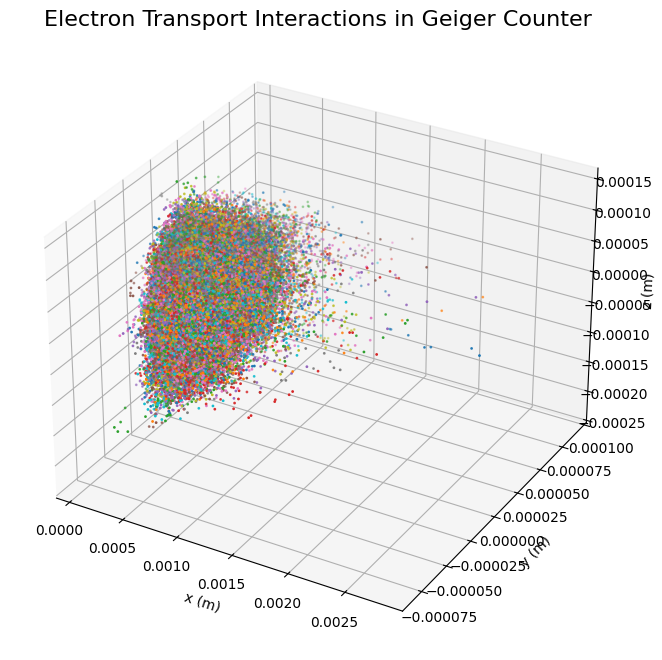

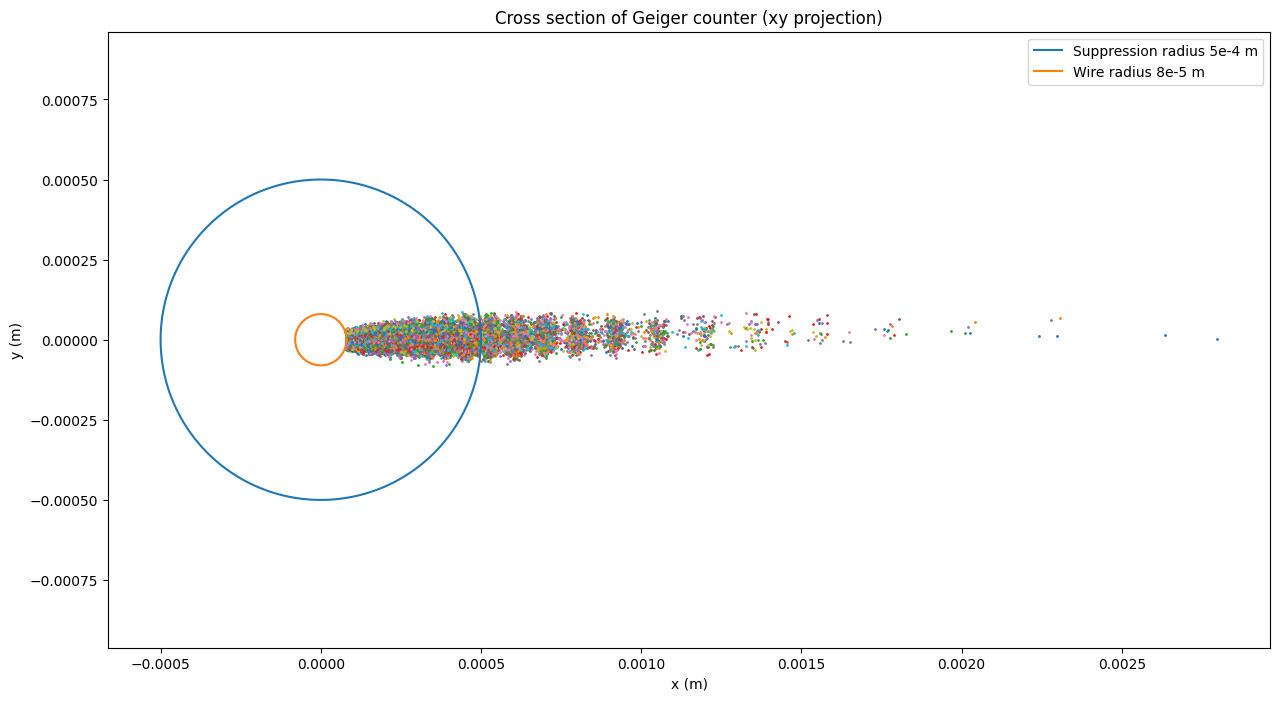

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


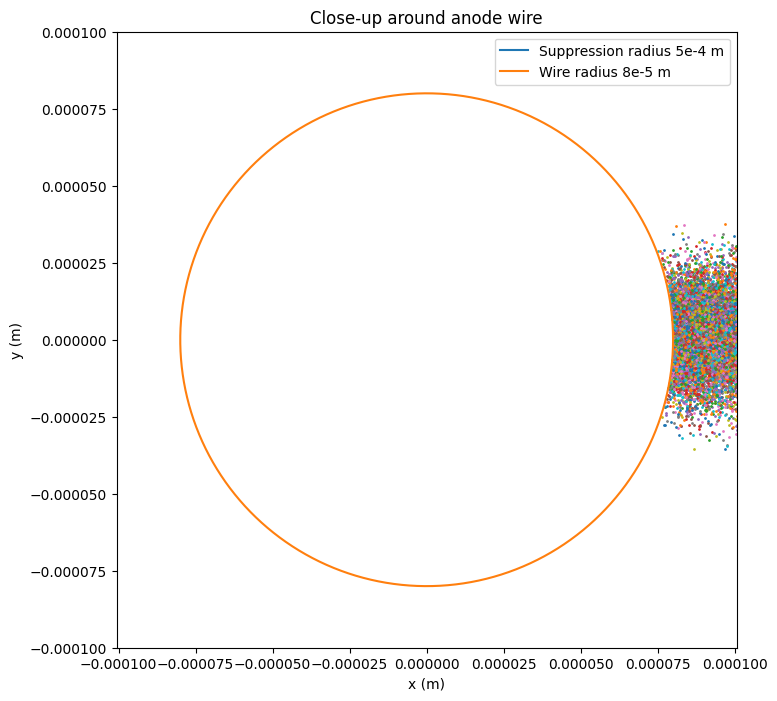

In [11]:
bias = 1000.0
r0 = 3.0e-3
charges0 = [np.array([r0, 0.0, 0.0])]

t0 = time.process_time()
res, times = run(charges0, bias)
t1 = time.process_time()
print("Process time:", t1 - t0)

plot_paths(res)

#### Plot and code: 15 marks; Speed effort: 5 marks

Feedback: